# Análise do Portfolio de Fundos

### Inicializações

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("whitegrid")


In [4]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv' # 'D:\\Personal\\Python\\Fundos\\exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

Date
2022-03-04    0.91343
2022-03-03    0.90367
2022-03-02    0.89982
2022-03-01    0.89844
2022-02-28    0.89167
Name: USD2EUR, dtype: float64

In [6]:
#Get the Portofolio
portfolio_csv = 'portofolio.csv' # 'D:\\Personal\\Python\\Fundos\\portofolio.csv'
df_portofolio = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
code2name_dict = {x[0]:x[1] for x in df_portofolio.itertuples()}
df_portofolio

,Nome,Moeda,Quantidade
Code,,,
IE00B19Z4C24,LM Royce US Sm Opp,EUR,11.277
IE00BLP5S353,Jupiter Glb Abs Rt,USD,15864.590
LU0046217351,JHH Pan Europea Small,EUR,73.812
LU0073232471,MS US Equity Growt,USD,11.487
LU0115767021,FF Latin America,EUR,77.040
LU0117884675,JPM Europ Dyn Tech,EUR,156.411
LU0121204431,NN Glb Sustain Eq,EUR,9.065
LU0122613903,T Eastern Europe,EUR,32.196
LU0147401714,BGF World Financia,USD,132.430


In [8]:
#Get the historical quotes 

xls = 'historico_cotacoes.xlsx' #'D:\Personal\Python\Fundos\historico_cotacoes.xlsx'
dict_df = pd.read_excel(xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date'], infer_datetime_format = True).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df = df_all.dropna()

#Create a DataFrame with the daily growth
df_grow = df.apply(lambda x: x/x.shift(-1), axis=0).dropna()


In [9]:
df_p = df_portofolio.copy()
df_cotacoes = df_all.fillna(method='bfill').fillna(method='pad')
df_total = df_cotacoes.apply(lambda x: sum(df_p['Quantidade'][k]*v*(exchange_rates[x.name] if df_p['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1)        
base_amount = df_total[-1]
std = (df_total/df_total.shift(-1)-1).dropna().std()
grow = df_total[0]/df_total[-1]-1
best_racio = grow / std
best_df_p = df_p['Quantidade']
for _ in range(1000):
    new_p = pd.Series(index=df_portofolio.index,data=[np.random.random()+0.5 for _ in df_portofolio.index])*best_df_p
    new_df_total = df_cotacoes.apply(lambda x: sum(new_p[k]*v*(exchange_rates[x.name] if df_p['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1)
    new_p *= base_amount/new_df_total[-1]
    std = (new_df_total/new_df_total.shift(-1)-1).dropna().std()
    new_grow = new_df_total[0]/new_df_total[-1]-1
    ratio = new_grow / std
    if ratio > best_racio and new_grow > grow:
        best_df_p = new_p
        best_racio = ratio
        best_df_total = new_df_total*base_amount/new_df_total[-1]
        #print(best_racio, grow,std)

print((best_df_total/best_df_total.shift(-1)-1).dropna().std(), best_df_total[0]/ best_df_total[-1]-1)
print(best_df_p)


KeyboardInterrupt: 

<AxesSubplot:>

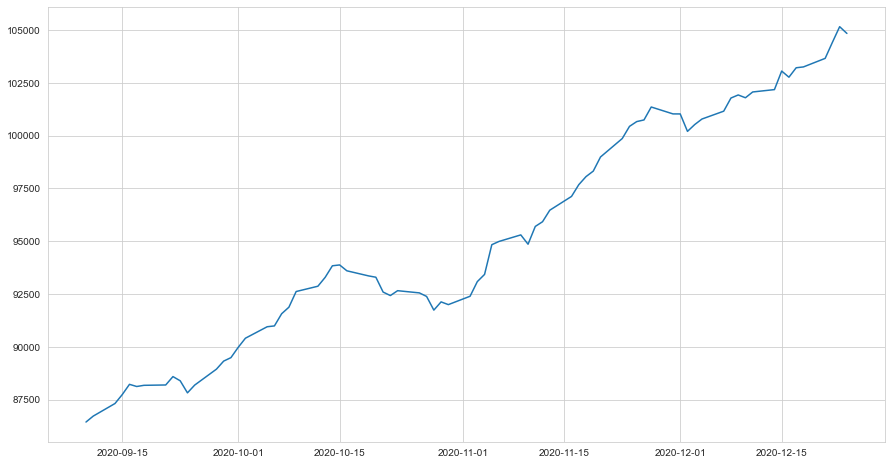

In [ ]:
best_df_total.plot(figsize=(15,8),grid=True)